# Recommendation system for e-commerce businesses
The recommendation system is designed in 3 parts based on the business context:

Recommendation system part I: Product pupularity based system targetted at new customers

Recommendation system part II: Model-based collaborative filtering system based on customer's purchase history and ratings provided by other users who bought items similar items

Recommendation system part III: When a business is setting up its e-commerce website for the first time withou any product rating

When a new customer without any previous purchase history visits the e-commerce website for the first time, he/she is recommended the most popular products sold on the company's website. Once, he/she makes a purchase, the recommendation system updates and recommends other products based on the purchase history and ratings provided by other users on the website. The latter part is done using collaborative filtering techniques.

## Recommendation System - Part I
### Product popularity based recommendation system targeted at new customers
Popularity based are a great strategy to target the new customers with the most popular products sold on a business's website and is very useful to cold start a recommendation engine.

**Importing libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import sklearn
from sklearn.decomposition import TruncatedSVD

**Loading the dataset**

In [2]:
df_transaction = pd.read_csv('../input/제6회 L.POINT Big Data Competition-분석용데이터-02.거래 정보.csv', parse_dates=['de_dt'])
df_product = pd.read_csv('../input/제6회 L.POINT Big Data Competition-분석용데이터-04.상품분류 정보.csv')

In [3]:
df_transaction.head()

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct
0,21922,104999,1,A03,unknown,2019-09-20,12:41,5990,1
1,21279,104907,4,A03,unknown,2019-09-20,10:27,10900,1
2,39423,105124,11,A03,unknown,2019-09-20,17:26,12900,1
3,18362,104010,1,A03,unknown,2019-09-20,09:57,9900,1
4,39423,105124,13,A03,0565,2019-09-20,17:26,2990,1


In [4]:
df_transaction.shape, df_product.shape

((599961, 9), (1667, 4))

In [5]:
# 'unknown' row add 
df_product = df_product.append(pd.Series([0, 'unknown', 'unknown', 'unknown'], index=df_product.columns ), ignore_index=True)

In [6]:
popular_product = pd.DataFrame(df_transaction.groupby('pd_c')['buy_ct'].count())
most_popular = popular_product.sort_values('buy_ct', ascending=False)
most_popular.head(10)

,buy_ct
pd_c,
unknown,17652
1213,15518
0347,12914
0964,11115
1395,11083
1617,10850
0221,10254
0354,8417
0114,7882


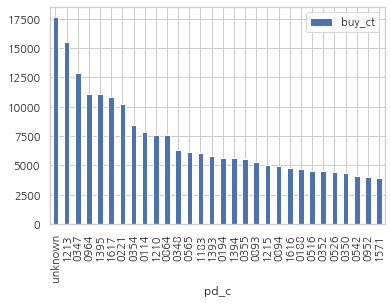

In [7]:
most_popular.head(30).plot(kind = "bar")

In [8]:
df_transaction.loc[df_transaction['pd_c'] == 'unknown', 'pd_c'] = '0000'
df_transaction['pd_c'] = df_transaction['pd_c'].astype(int)
popular_product = pd.DataFrame(df_transaction.groupby('pd_c')['buy_ct'].count())
most_popular = popular_product.sort_values('buy_ct', ascending=False).reset_index()
df = pd.merge(most_popular, df_product, how='left')
df.head(10)

,pd_c,buy_ct,clac_nm1,clac_nm2,clac_nm3
0,0,17652,unknown,unknown,unknown
1,1213,15518,Snack Foods,Snacks,General Snacks
2,347,12914,Dairy Products,Milk,Fresh Milk
3,964,11115,Meats,Eggs,Chicken Eggs
4,1395,11083,Substitute Foods,Instant Noodles,Ramens
5,1617,10850,Vegetables,Tofu / Bean Sprouts,Tofu
6,221,10254,Cleaning / Laundry / Bathroom Accessories,Cleaning Accessories,Trash Bags
7,354,8417,Dairy Products,Yogurt,Spoon Type Yogurts
8,114,7882,Beverages,Water,Water
9,1210,7610,Snack Foods,Snacks,Corn Snacks


*Analysis:*
The above graph gives us the most popular products(arranged in descending order) sold by the business.

## Recommendation System - part II

### Model-based collaborative filtering system

Recommend items to users based on purchase history and similarity of ratings provided by other users who bought items to that of a prticular customer.

A model based collaborative filtering technique is closen here as it helps in making predicting products for a particular user by identifying patterns based on preferences from multiple user data.

**Utility Matrix based on products sold and buy counts**

Utility Matrix

An utility is consists of all possible user-item preferences (buy count) details represented as a matrix.
The utility matrix is sparse most of the values are unknown.

In [9]:
buy_ct_utility_matrix = df_transaction.pivot_table(values='buy_ct', index='clnt_id', columns='pd_c', fill_value=0)
buy_ct_utility_matrix.head()

pd_c,0,1,2,3,4,5,6,7,8,9,...,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667
clnt_id,,,,,,,,,,,,,,,,,,,,,
2,0.0,0,0,0,0,0.0,0.0,0,0,0,...,0.0,0,0,0.0,0,0.0,0,0,0.0,0
9,0.0,0,0,0,0,0.0,0.0,0,0,0,...,0.0,0,0,0.0,0,0.0,0,0,0.0,0
12,1.0,0,0,0,0,0.0,0.0,0,0,0,...,0.0,0,0,0.0,0,0.0,0,0,0.0,0
20,1.0,0,0,0,0,0.0,0.0,0,0,0,...,0.0,0,0,0.0,0,0.0,0,0,0.0,0
23,0.0,0,0,0,0,0.0,0.0,0,0,0,...,0.0,0,0,0.0,0,0.0,0,0,0.0,0


As expected, the utility matrix obtaned above is sparse, I have filled up the unknown values with 0.

In [10]:
buy_ct_utility_matrix.shape

(11284, 1668)

Transposing the matirx

In [11]:
X = buy_ct_utility_matrix.T
X.T.head()

pd_c,0,1,2,3,4,5,6,7,8,9,...,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667
clnt_id,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
X.shape

(1668, 11284)

Unique products in subset of data

In [13]:
X1 = X

### Decomposing the Matrix

In [44]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(1668, 10)

### Correlation Matrix

In [45]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(1668, 1668)

### Isolation Product ID #928 from the Correltaion Matirx
Assuming the customer buys Product ID #928 (randomly chosen)

In [46]:
X.index[928]

928

Index # of product ID purchased by customer

In [56]:
i = 11

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

11

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product.

In [57]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(1668,)

### Recommending top 10 highly correlated product in sequence

In [58]:
Recommend = list(X.index[correlation_product_ID > 0.90])

# Removes the item already bought by the customer
Recommend.remove(i)

In [59]:
Recommend[0:9]

[48, 49, 68, 81, 94, 100, 142, 160, 181]

Product ID # 

Here are the top 10 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website.